In [2]:
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from matplotlib import pyplot
import matplotlib
from flask import Flask, jsonify

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn=engine.connect()

In [7]:
# reflect an existing database into a new model
base=automap_base()
base.prepare(engine, reflect=True)
# reflect the tables


In [8]:
# We can view all of the classes that automap found
base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
measurement = base.classes.measurement
station=base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session=Session(engine)

# Exploratory Climate Analysis

Text(0.5, 0, 'Date (2016 to 2017)')

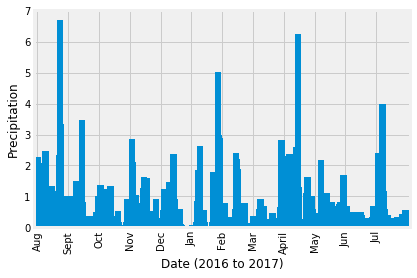

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

#Calculate the date 1 year ago from the last data point in the database


#--- get the dates
datelist=session.query(measurement.date).\
    order_by(measurement.date).all()

#--------recent
lastdate=(max(datelist))[0]

#--------12 months beforehand
timeobject=datetime.strptime(lastdate, '%Y-%m-%d')
firstdate_obj=(timeobject-timedelta(days=365))
firstdate=str(firstdate_obj).split(" ")[0]

# Perform a query to retrieve the data and precipitation scores
#---get data from those dates
data=session.query(measurement.date, measurement.prcp).\
    filter(func.strftime("%Y-%m-%d", measurement.date) > firstdate,func.strftime("%Y-%m-%d", measurement.date) < lastdate ).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
rain_data_noin = pd.DataFrame(data)
rain_data = pd.DataFrame(data).set_index("date")

# Sort the dataframe by date
sorted_df=rain_data.sort_values(by=['date'])


# Use Pandas Plotting with Matplotlib to plot the data
x_labels=("Aug","Sept","Oct","Nov","Dec","Jan","Feb", "Mar", "April", "May", "Jun", "Jul")
ticks=np.arange(len(sorted_df))
plot=sorted_df.plot(kind="bar", width=40, legend=False)
plot.locator_params(axis='x', nbins=12)
plot.set_xticklabels(x_labels, rotation=90)
plt.ylabel("Precipitation")
plt.xlabel("Date (2016 to 2017)")

In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
mean_rain=sorted_df["prcp"].mean()
sd_rain=sorted_df['prcp'].std()
var_rain=sd_rain**2
max_rain=sorted_df["prcp"].max()
min_rain=sorted_df["prcp"].min()
quartile1=sorted_df['prcp'].quantile(q=0.25)
median_rain=sorted_df['prcp'].median()
quartile3=sorted_df['prcp'].quantile(q=0.75)

summary_stats = {
    'Mean':  [mean_rain],
    'SD': [sd_rain],
    'Min': [min_rain],
    'Max': [max_rain],
    'Quartile 1': [quartile1],
    'Quartile 2': [median_rain],
    'Quartile 3':[quartile3]}
summary_df = pd.DataFrame (summary_stats, columns = ['Mean','SD', "Min","Max","Quartile 1", "Quartile 2", "Quartile 3"])
summary_df

,Mean,SD,Min,Max,Quartile 1,Quartile 2,Quartile 3
0,0.176549,0.460667,0.0,6.7,0.0,0.02,0.13


In [15]:
# Design a query to show how many stations are available in this dataset
station_count = pd.read_sql("SELECT station, count(station) FROM measurement WHERE station NOT NULL GROUP BY station ORDER BY count(station) DESC", conn)
station_totals=pd.DataFrame(station_count)
print(f"There are {len(station_count)} stations in this dataset.")

There are 9 stations in this dataset.


In [18]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

max_count=station_count["count(station)"].max()
max_row=station_count.loc[station_count["count(station)"]==max_count]
rawmax=str(max_row["station"])
maxno=str(rawmax)
maxno=maxno.split(" ")[4]
maxno=maxno.split("\n")
maxno=maxno[0]
maxno

min_count=station_count["count(station)"].min()
min_row=station_count.loc[station_count["count(station)"]==min_count]
minno=str(min_row["station"])
minno=minno.split(" ")[4]
minno=minno.split("\n")
minno=minno[0]
minno

print(station_count)

#new.loc[new["Timepoint"]==timepoints[0]]
#min_count=station_count["count(station)"].min()
print(f"The most active station is {maxno} with {max_count} total measurements.")
print(f"The least active statement is {minno} with {min_count} total measurements.")

       station  count(station)
0  USC00519281            2772
1  USC00519397            2724
2  USC00513117            2709
3  USC00519523            2669
4  USC00516128            2612
5  USC00514830            2202
6  USC00511918            1979
7  USC00517948            1372
8  USC00518838             511
The most active station is USC00519281 with 2772 total measurements.
The least active statement is USC00518838 with 511 total measurements.


In [16]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station
maxstation_df=measurement_data.loc[measurement_data["station"]==maxno]
min_temp=maxstation_df["tobs"].min()
max_temp=maxstation_df["tobs"].max()
avg_temp=maxstation_df["tobs"].mean()

active_stats = {
    'Station': [maxno],
    'Mean':  [avg_temp],
    'Min': [min_temp],
    'Max': [max_temp],}
active_df = pd.DataFrame (active_stats, columns = ['Station','Mean',"Min","Max"])
active_df

,Station,Mean,Min,Max
0,USC00519281,71.663781,54.0,85.0


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


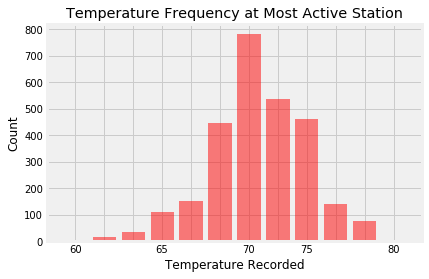

In [36]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
#NOTE: this cell returns an error message but works anyway

tempmos_df=maxstation_df[["station", "tobs"]]
#create 
tempmos_df['temp_bracket'] = pd.cut(tempmos_df['tobs'], bins=12)
#station_count = pd.read_sql("SELECT station, count(station) FROM measurement WHERE tobs NOT NULL GROUP BY station ORDER BY count(station) DESC", conn)
tempmos_counts_df=tempmos_df.groupby(['temp_bracket']).count()
tempmos_counts_df=tempmos_counts_df[["station"]]
ticks=np.arange(len(tempmos_counts_df))


x_labels=("60"," "," ","65"," ","","70", " ", "75", " ", " ", "80")
xpos2=np.arange(len(tempmos_counts_df))
tick_locations=[value for value in xpos2]
plt.bar(xpos2, tempmos_counts_df["station"], color='r', alpha=0.5, align="center")
plt.xticks(tick_locations, x_labels, rotation="horizontal")
plt.title("Temperature Frequency at Most Active Station")
plt.ylabel("Count")
plt.xlabel("Temperature Recorded")
plt.savefig("Resources/temps_at_most_active_station.png")
plt.show()


## Bonus Challenge Assignment

In [24]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):

    calc_temps=session.query(measurement.date, measurement.tobs).\
        filter(func.strftime("%Y-%m-%d", measurement.date) > start_date,func.strftime("%Y-%m-%d", measurement.date) < end_date).all()
    calc_pd = pd.DataFrame(calc_temps).set_index("date")
    
    TMIN=calc_pd["tobs"].min()
    TMAX=calc_pd["tobs"].max()
    TAVG=calc_pd["tobs"].mean()
    
    calc_stats = {
    'Mean Temp':[TAVG],
    'Min Temp': [TMIN],
    'Max Temp': [TMAX]}
    
    calc_df = pd.DataFrame (calc_stats, columns = ['Mean Temp','Min Temp',"Max Temp"])
    
    print(f"The following table presents the average, minimum, and maximum temperatures recorded between the dates\n{start_date} and {end_date}.\n")
    print(calc_df)

In [25]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates. 

calc_temps('2017-08-08', lastdate)

The following table presents the average, minimum, and maximum temperatures recorded between the dates
2017-08-08 and 2017-08-23.

   Mean Temp  Min Temp  Max Temp
0  78.527273      70.0      85.0


Text(0.5, 0, 'Date (2016 to 2017)')

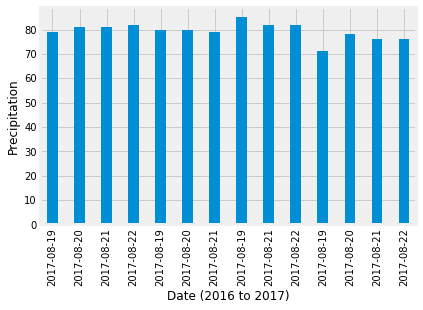

In [79]:
# Plot the results from your previous query as a bar chart. 
mytrip_temps=session.query(measurement.date, measurement.tobs).\
        filter(func.strftime("%Y-%m-%d", measurement.date) > '2017-08-18',func.strftime("%Y-%m-%d", measurement.date) < lastdate).all()
mytrip_df = pd.DataFrame(mytrip_temps).set_index("date")

ticks=np.arange(len(mytrip_df))
plot=mytrip_df.plot(kind="bar", width=.4, legend=False)
#plot.locator_params(axis='x', nbins=12)
#plot.set_xticklabels(x_labels, rotation=90)
plt.ylabel("Precipitation")
plt.xlabel("Date (2016 to 2017)")

In [22]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [23]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

NameError: name 'Measurement' is not defined

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`


In [ ]:
station_data

In [ ]:
measurement_data

In [ ]:
#Inner join the two tables on all variables
full_data=session.query(station.id, station.station, station.latitude,\
station.longitude, station.elevation, measurement.date, measurement.prcp, measurement.tobs) \
.filter(measurement.station == station.station).all()

full_pd = pd.DataFrame(full_data).set_index("id")
full_pd


In [ ]:
sel=[measurement.station, station.station]

In [ ]:
#Convert the query results to a dictionary using date as the key and prcp as the value.

In [29]:
latest_date = session.query(func.max(func.strftime("%Y-%m-%d", measurement.date))).all()


'2017-08-23'

In [110]:
station_count = pd.read_sql("SELECT station, count(station) FROM measurement WHERE station NOT NULL GROUP BY station ORDER BY count(station) DESC", conn)
  
   
#select the most active station
max_count=station_count['count(station)'].max()
max_row=station_count.loc[station_count["count(station)"]==max_count]

#extract the string of the most active station name
rawname=str(max_row["station"])
string_it=str(rawname)
split_it=string_it.split(" ")[4]
split_again=split_it.split("\n")
station_name=split_again[0]

#get only the data from the relevant station from the dataset
maxstation_df=measurement_data.loc[measurement_data["station"]==station_name]

# dropping null value columns to avoid errors 
maxstation_df.dropna(inplace = True) 
 

# converting to dict 
dict_df=maxstation_df[['date', 'tobs']].set_index(["date"])
data_dict = dict_df.to_dict() 

jsonify(data_dict)

In [117]:
# dropping null value columns to avoid errors 
maxstation_df.dropna(inplace = True) 
 

# converting to dict 
dict_df=maxstation_df[['date', 'tobs']].set_index(["date"])
data_dict = dict_df.to_dict() 
  
# display 
data_dict 

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


{'tobs': {'2010-01-01': 70.0,
  '2010-01-02': 62.0,
  '2010-01-03': 74.0,
  '2010-01-04': 75.0,
  '2010-01-05': 74.0,
  '2010-01-06': 76.0,
  '2010-01-07': 69.0,
  '2010-01-08': 66.0,
  '2010-01-09': 70.0,
  '2010-01-10': 75.0,
  '2010-01-11': 64.0,
  '2010-01-12': 60.0,
  '2010-01-13': 61.0,
  '2010-01-14': 68.0,
  '2010-01-15': 64.0,
  '2010-01-16': 66.0,
  '2010-01-17': 67.0,
  '2010-01-18': 70.0,
  '2010-01-19': 67.0,
  '2010-01-20': 67.0,
  '2010-01-21': 69.0,
  '2010-01-22': 60.0,
  '2010-01-23': 75.0,
  '2010-01-24': 75.0,
  '2010-01-25': 65.0,
  '2010-01-26': 75.0,
  '2010-01-27': 69.0,
  '2010-01-28': 67.0,
  '2010-01-29': 66.0,
  '2010-01-30': 69.0,
  '2010-01-31': 72.0,
  '2010-02-01': 67.0,
  '2010-02-02': 65.0,
  '2010-02-03': 64.0,
  '2010-02-04': 67.0,
  '2010-02-05': 67.0,
  '2010-02-06': 68.0,
  '2010-02-07': 69.0,
  '2010-02-08': 66.0,
  '2010-02-09': 69.0,
  '2010-02-10': 61.0,
  '2010-02-11': 71.0,
  '2010-02-12': 70.0,
  '2010-02-13': 70.0,
  '2010-02-14': 66.0,
  

In [119]:
world={'hello':'world'}

In [114]:
dict_df=maxstation_df[['date', 'tobs']].set_index(["date"])

In [120]:
jsonify(world)

RuntimeError: Working outside of application context.

This typically means that you attempted to use functionality that needed
to interface with the current application object in some way. To solve
this, set up an application context with app.app_context().  See the
documentation for more information.

In [121]:
return("test")

SyntaxError: 'return' outside function (<ipython-input-121-bfd720c955ab>, line 1)